In [1]:
import torch
import torch.nn as nn
import tiktoken

In [2]:
from gpt_model import * 

In [3]:
tokenizer = tiktoken.get_encoding("gpt2")

In [4]:
model = GPTModel(GPT_CONFIG_124M)

In [5]:
start_context = "Every effort moves you"

In [6]:
token_ids = generate_text_sample(
    model=model,
    idx=text_to_token_ids(start_context, tokenizer),
    max_new_tokens=10,
    context_size=GPT_CONFIG_124M["context_length"]
)

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you ¶ Rudy2006 predominant although beesIsa shoe socio Argument


In [7]:
inputs = torch.tensor([[16833, 3626, 6100],   # ["every effort moves",
                       [40,    1107, 588]])   #  "I really like"]

targets = torch.tensor([[3626, 6100, 345  ],  # [" effort moves you",
                        [1107,  588, 11311]]) #  " really like chocolate"]

In [8]:
with torch.no_grad():
    logits = model(inputs)

probs = torch.softmax(logits, dim=-1) # Probability of each token in vocabulary
print(probs.shape) # Shape: (batch_size, num_tokens, vocab_size)

torch.Size([2, 3, 50257])


In [9]:
probs

tensor([[[1.5150e-05, 1.9112e-05, 1.4124e-05,  ..., 2.9581e-05,
          2.6250e-05, 3.1036e-05],
         [1.9896e-05, 2.3788e-05, 1.1806e-05,  ..., 2.2520e-05,
          2.8345e-05, 3.0338e-05],
         [1.1531e-05, 1.8426e-05, 1.0007e-05,  ..., 1.5067e-05,
          1.0548e-05, 2.8059e-05]],

        [[2.5014e-05, 1.8053e-05, 1.6717e-05,  ..., 1.9039e-05,
          2.8213e-05, 1.9410e-05],
         [2.5156e-05, 3.3724e-05, 2.5107e-05,  ..., 1.9150e-05,
          3.3338e-05, 2.1774e-05],
         [1.1798e-05, 1.5209e-05, 2.7672e-05,  ..., 1.5036e-05,
          1.2598e-05, 9.0043e-06]]])

In [10]:
# predicted tokens:
token_ids = torch.argmax(probs, dim=-1, keepdim=True)
print("Token IDs:\n", token_ids)

Token IDs:
 tensor([[[47986],
         [45934],
         [29719]],

        [[26426],
         [19612],
         [14735]]])


In [11]:
print(f"Targets batch 1: {token_ids_to_text(targets[0], tokenizer)}")
print(f"Outputs batch 1: {token_ids_to_text(token_ids[0].flatten(), tokenizer)}")

Targets batch 1:  effort moves you
Outputs batch 1:  Neural elaboratedisoft


In [12]:
print(f"Targets batch 2: {token_ids_to_text(targets[1], tokenizer)}")
print(f"Outputs batch 2: {token_ids_to_text(token_ids[1].flatten(), tokenizer)}")

Targets batch 2:  really like chocolate
Outputs batch 2: ensing subway magnitude


In [13]:
targets

tensor([[ 3626,  6100,   345],
        [ 1107,   588, 11311]])

In [14]:
text_idx = 0
target_probs_1 = probs[text_idx, [0, 1, 2], targets[text_idx]]
print("Text 1:", target_probs_1)

text_idx = 1
target_probs_2 = probs[text_idx, [0, 1, 2], targets[text_idx]]
print("Text 2:", target_probs_2)

Text 1: tensor([2.2860e-05, 2.3735e-05, 1.5887e-05])
Text 2: tensor([2.7487e-05, 4.1521e-05, 1.7513e-05])


In [15]:
torch.set_printoptions( sci_mode=False )

In [16]:
# Compute logarithm of all token probabilities
log_probs = torch.log(torch.cat((target_probs_1, target_probs_2)))
print(log_probs)

tensor([-10.6861, -10.6486, -11.0500, -10.5018, -10.0893, -10.9525])


In [17]:
avg_log_probs = torch.mean(log_probs)
print(avg_log_probs)
neg_avg_log_probs = avg_log_probs * -1
print(neg_avg_log_probs)


tensor(-10.6547)
tensor(10.6547)


In [18]:
print("Logits shape:", logits.shape)
print("Targets shape:", targets.shape)

Logits shape: torch.Size([2, 3, 50257])
Targets shape: torch.Size([2, 3])


In [19]:
logits_flat = logits.flatten(0, 1)
targets_flat = targets.flatten()
print("Flattened logits:", logits_flat.shape)
print("Flattened targets:", targets_flat.shape)

Flattened logits: torch.Size([6, 50257])
Flattened targets: torch.Size([6])


In [20]:
loss = torch.nn.functional.cross_entropy(logits_flat, targets_flat)
print(loss)

perplexity = torch.exp(loss)
print("Perplexity:", perplexity)

tensor(10.6547)
Perplexity: tensor(42392.1055)


In [21]:
# use short story from before for training
with open( "../data/gautier.txt", "r" ) as f:
    text_data = f.read()
print(text_data[:500])  # print first 500 characters

Had given orders that day to deny my door to every one; having made a solemn resolution that morning that I would do nothing, I did not wish to be disturbed in that important occupation. With a feeling of confidence that I should not be bothered by bores (there are some left yet besides those in Molière's comedy), I had concerted all my measures to enjoy the pleasure of my predilection at my ease.

A bright fire was blazing in my chimney, the curtains were drawn and admitted a dim mysterious lig


In [22]:
total_characters = len(text_data)
total_tokens = len(tokenizer.encode(text_data))

print("Characters:", total_characters)
print("Tokens:", total_tokens)


Characters: 54532
Tokens: 12805


In [23]:
# Dataset splits overlapping token windows into input/target pairs for next-token prediction
from torch.utils.data import Dataset, DataLoader


class GPTDatasetV1(Dataset):
    def __init__(self, txt, tokenizer, max_length, stride):
        self.input_ids = []
        self.target_ids = []

        # Tokenize the entire text
        token_ids = tokenizer.encode(txt, allowed_special={"<|endoftext|>"})
        assert len(token_ids) > max_length, "Number of tokenized inputs must at least be equal to max_length+1"

        # Use a sliding window to chunk the book into overlapping sequences of max_length
        for i in range(0, len(token_ids) - max_length, stride):
            input_chunk = token_ids[i:i + max_length]
            target_chunk = token_ids[i + 1: i + max_length + 1]
            self.input_ids.append(torch.tensor(input_chunk))
            self.target_ids.append(torch.tensor(target_chunk))

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):
        return self.input_ids[idx], self.target_ids[idx]

def create_dataloader_v1(txt, batch_size=4, max_length=256, 
                         stride=128, shuffle=True, drop_last=True,
                         num_workers=0):

    # Initialize the tokenizer
    tokenizer = tiktoken.get_encoding("gpt2")

    # Create dataset
    dataset = GPTDatasetV1(txt, tokenizer, max_length, stride)

    # Create dataloader
    dataloader = DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        drop_last=drop_last,
        num_workers=num_workers
    )

    return dataloader

In [24]:
# separate text into training and validation sets:
# Train/validation ratio
# Split raw text into train/validation chunks before building loaders
train_ratio = 0.90
split_idx = int(train_ratio * len(text_data))
train_data = text_data[:split_idx]
val_data = text_data[split_idx:]

torch.manual_seed(123)

train_loader = create_dataloader_v1(
    train_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=True,
    shuffle=True,
    num_workers=0
)

val_loader = create_dataloader_v1(
    val_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=False,
    shuffle=False,
    num_workers=0
)

In [25]:
# Count total tokens that will contribute to loss in each split
train_tokens = 0
for input_batch, target_batch in train_loader:
    train_tokens += input_batch.numel()

val_tokens = 0
for input_batch, target_batch in val_loader:
    val_tokens += input_batch.numel()

print("Training tokens:", train_tokens)
print("Validation tokens:", val_tokens)
print("All tokens:", train_tokens + val_tokens)

Training tokens: 10240
Validation tokens: 1024
All tokens: 11264


In [26]:
# Calculate loss over a single batch
def calc_loss_batch(input_batch, target_batch, model, device):
    input_batch, target_batch = input_batch.to(device), target_batch.to(device)
    logits = model(input_batch)
    loss = torch.nn.functional.cross_entropy(logits.flatten(0, 1), target_batch.flatten())
    return loss

# Calculate loss over a data loader
def calc_loss_loader(data_loader, model, device, num_batches=None):
    total_loss = 0.
    if len(data_loader) == 0:
        return float("nan")
    elif num_batches is None:
        num_batches = len(data_loader)
    else:
        # Reduce the number of batches to match the total number of batches in the data loader
        # if num_batches exceeds the number of batches in the data loader
        num_batches = min(num_batches, len(data_loader))
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            total_loss += loss.item()
        else:
            break
    return total_loss / num_batches

In [27]:
# Choose the fastest available device
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    # Use PyTorch 2.9 or newer for stable mps results
    major, minor = map(int, torch.__version__.split(".")[:2])
    if (major, minor) >= (2, 9):
        device = torch.device("mps")
else:
    device = torch.device("cpu")

print(f"Using {device} device.")


model.to(device) # no assignment model = model.to(device) necessary for nn.Module classes

torch.manual_seed(123) # For reproducibility due to the shuffling in the data loader

with torch.no_grad(): # Disable gradient tracking for efficiency because we are not training, yet
    train_loss = calc_loss_loader(train_loader, model, device)
    val_loss = calc_loss_loader(val_loader, model, device)

print("Training loss:", train_loss)
print("Validation loss:", val_loss)

Using cpu device.
Training loss: 10.995188903808593
Validation loss: 11.017396926879883


In [28]:
def train_model_simple(model, train_loader, val_loader, optimizer, device, num_epochs,
                       eval_freq, eval_iter, start_context, tokenizer):
    # Track losses and how many tokens the model has seen
    train_losses, val_losses, track_tokens_seen = [], [], []
    tokens_seen, global_step = 0, -1

    # Main training loop
    for epoch in range(num_epochs):
        model.train()  # Set model to training mode
        
        for input_batch, target_batch in train_loader:
            optimizer.zero_grad() # Reset loss gradients from previous batch iteration
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            loss.backward() # Calculate loss gradients
            optimizer.step() # Update model weights using loss gradients
            tokens_seen += input_batch.numel()
            global_step += 1

            # Optional evaluation step
            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model(
                    model, train_loader, val_loader, device, eval_iter)
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                track_tokens_seen.append(tokens_seen)
                print(f"Ep {epoch+1} (Step {global_step:06d}): "
                      f"Train loss {train_loss:.3f}, Val loss {val_loss:.3f}")

        # Print a sample text after each epoch
        generate_and_print_sample(
            model, tokenizer, device, start_context
        )

    return train_losses, val_losses, track_tokens_seen


def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    model.eval()
    with torch.no_grad():
        train_loss = calc_loss_loader(train_loader, model, device, num_batches=eval_iter)
        val_loss = calc_loss_loader(val_loader, model, device, num_batches=eval_iter)
    model.train()
    return train_loss, val_loss


def generate_and_print_sample(model, tokenizer, device, start_context):
    model.eval()
    context_size = model.pos_emb.weight.shape[0]
    encoded = text_to_token_ids(start_context, tokenizer).to(device)
    with torch.no_grad():
        token_ids = generate_text_sample(
            model=model, idx=encoded,
            max_new_tokens=50, context_size=context_size
        )
    decoded_text = token_ids_to_text(token_ids, tokenizer)
    print(decoded_text.replace("\n", " "))  # Compact print format
    model.train()

In [30]:
# Note:
# Uncomment the following code to calculate the execution time
# import time
# start_time = time.time()

# Training run with periodic evaluation to track overfitting
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0004, weight_decay=0.1)

num_epochs = 10
train_losses, val_losses, tokens_seen = train_model_simple(
    model, train_loader, val_loader, optimizer, device,
    num_epochs=num_epochs, eval_freq=5, eval_iter=5,
    start_context="Every effort moves you", tokenizer=tokenizer
)

# Note:
# Uncomment the following code to show the execution time
# end_time = time.time()
# execution_time_minutes = (end_time - start_time) / 60
# print(f"Training completed in {execution_time_minutes:.2f} minutes.")

Ep 1 (Step 000000): Train loss 9.821, Val loss 9.995
Every effort moves you, the, the,,, the,, the,,,,,,,,,, the,,,,,, the,,,,,,,,,,,,,,,,,,,,,
Ep 2 (Step 000005): Train loss 7.951, Val loss 8.256
Every effort moves you the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the
Ep 3 (Step 000010): Train loss 6.726, Val loss 7.112
Every effort moves you, and the the the, and the, and the, and the, and the, and the, and the, and the, and the the the, and the, and the, and the, and the, and the, and the,
Ep 4 (Step 000015): Train loss 6.219, Val loss 6.764
Every effort moves you, and the the                                              
Ep 5 (Step 000020): Train loss 5.979, Val loss 6.599
Every effort moves you, and the to the to the" of the her, and the of the her, and the of the of the of the of the of the of the of the of the of the her, and, and,

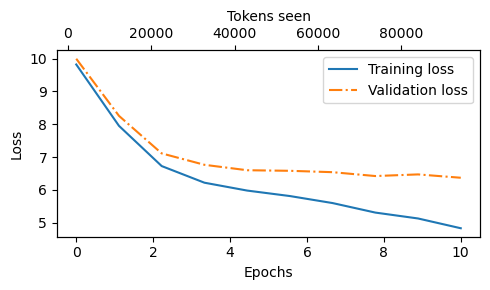

In [31]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator


def plot_losses(epochs_seen, tokens_seen, train_losses, val_losses):
    fig, ax1 = plt.subplots(figsize=(5, 3))

    # Plot training and validation loss against epochs
    ax1.plot(epochs_seen, train_losses, label="Training loss")
    ax1.plot(epochs_seen, val_losses, linestyle="-.", label="Validation loss")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
    ax1.legend(loc="upper right")
    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))  # only show integer labels on x-axis

    # Create a second x-axis for tokens seen to show training progress in data units
    ax2 = ax1.twiny()  # Create a second x-axis that shares the same y-axis
    ax2.plot(tokens_seen, train_losses, alpha=0)  # Invisible plot for aligning ticks
    ax2.set_xlabel("Tokens seen")

    fig.tight_layout()  # Adjust layout to make room
    plt.savefig("loss-plot.pdf")
    plt.show()

epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)

In [32]:
inference_device = torch.device("cpu")

model.to(inference_device)
model.eval()

tokenizer = tiktoken.get_encoding("gpt2")

token_ids = generate_text_sample(
    model=model,
    idx=text_to_token_ids("Every effort moves you", tokenizer).to(inference_device),
    max_new_tokens=25,
    context_size=GPT_CONFIG_124M["context_length"]
)

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you in the princess the princess, and the princess, and a, and that he was, and the princess, and the princess


I do not know what happened in my training, my code seems fine, but each epoch only last one step, i ran the code as intructed but ran into this issue

In [33]:
# read the book for more details and examples!
# temperature scaling and top-k sampling together increase 
# the diversity of predictions

def generate(model, idx, max_new_tokens, context_size, temperature=0.0, top_k=None, eos_id=None):

    # For-loop is the same as before: Get logits, and only focus on last time step
    for _ in range(max_new_tokens):
        idx_cond = idx[:, -context_size:]
        with torch.no_grad():
            logits = model(idx_cond)
        logits = logits[:, -1, :]

        # New: Filter logits with top_k sampling
        if top_k is not None:
            # Keep only top_k values
            top_logits, _ = torch.topk(logits, top_k)
            min_val = top_logits[:, -1]
            logits = torch.where(logits < min_val, torch.tensor(float("-inf")).to(logits.device), logits)

        # New: Apply temperature scaling
        if temperature > 0.0:
            logits = logits / temperature

            # New (not in book): numerical stability tip to get equivalent results on mps device
            # subtract rowwise max before softmax
            logits = logits - logits.max(dim=-1, keepdim=True).values
            
            # Apply softmax to get probabilities
            probs = torch.softmax(logits, dim=-1)  # (batch_size, context_len)

            # Sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1)  # (batch_size, 1)

        # Otherwise same as before: get idx of the vocab entry with the highest logits value
        else:
            idx_next = torch.argmax(logits, dim=-1, keepdim=True)  # (batch_size, 1)

        if idx_next == eos_id:  # Stop generating early if end-of-sequence token is encountered and eos_id is specified
            break

        # Same as before: append sampled index to the running sequence
        idx = torch.cat((idx, idx_next), dim=1)  # (batch_size, num_tokens+1)

    return idx

In [34]:
token_ids = generate(
    model=model,
    idx=text_to_token_ids("Every effort moves you", tokenizer).to(inference_device),
    max_new_tokens=15,
    context_size=GPT_CONFIG_124M["context_length"],
    top_k=25,
    temperature=1.4
)

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you; in the shop.

As he was a per to the and
